# Homework 11

Fit an autoencoder to the chest xray medical mnist dataset. Do the following
1. Evaluate and compare the training and testing erorr of the autoencoder.
2. Show the result of feeding a few training and testing images through the autoencoder.

You should submit a single ipynb with your results.

You can install the medical mnist data with the command below. Followin is a set of commands to download the data and load it into a pytorch dataset.

In [184]:
#pip install medmnist

In [185]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import medmnist
from medmnist import INFO, Evaluator

# work on a 2D dataset
data_flag = 'chestmnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [186]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/Farzad/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/Farzad/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/Farzad/.medmnist/chestmnist.npz


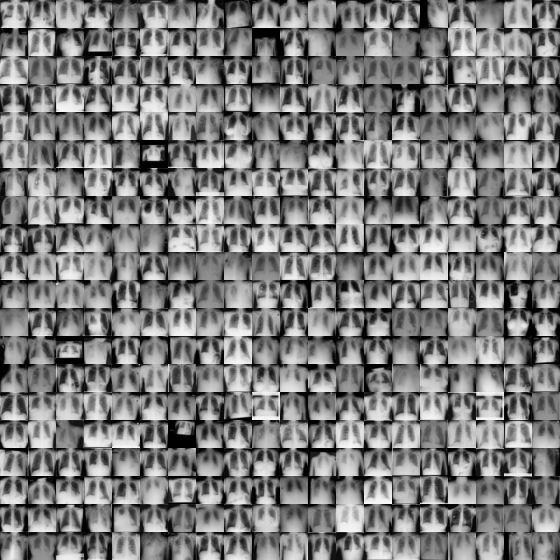

In [187]:
## Visualize the data
train_dataset.montage(length=20)

In [188]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset ChestMNIST (chestmnist)
    Number of datapoints: 78468
    Root location: /Users/Farzad/.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Dataset ChestMNIST (chestmnist)
    Number of datapoints: 22433
    Root location: /Us

In [189]:
kernel_size = 5
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size)
        self.conv2 = nn.Conv2d(6, 12, kernel_size)
        self.pool  = nn.MaxPool2d(2, 2)
        self.iconv1 = nn.ConvTranspose2d(12, 6, kernel_size+1, stride = 1)
        self.iconv2 = nn.ConvTranspose2d(6, 1, kernel_size+1, stride = 1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x
    
    def decode(self, x):
        x = F.relu(self.iconv1(x))
        ## Use the sigmoid as the final layer 
        ## since we've normalized pixel values to be between 0 and 1
        x = torch.sigmoid(self.iconv2(x))
        return(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))
    
model = autoencoder()

In [190]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

  0%|          | 0/614 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (14) must match the size of tensor b (128) at non-singleton dimension 2

In [ ]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')